In [1]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 22px;
</style>

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
    # logical_gpus = tf.config.list_logical_devices('GPU')
    # print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2023-04-28 16:39:40.697354: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 16:39:40.837145: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-28 16:39:41.475178: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-28 16:39:41.475233: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [48]:
import numpy as np
import os

node_num = 16
training_id = 0
check_point = 279
end_point = 280

folder_path = os.path.join(os.getcwd(), '../learn_output')
file_path = os.path.join(folder_path, 'weight50_%d_%d.npy' % (node_num, training_id))

weight = np.load(file_path, allow_pickle=True)

x_train = weight[:-1,:]
y_train = weight[1:,:]

for training_id in range(1, check_point):
    file_path = os.path.join(folder_path, 'weight50_%d_%d.npy' % (node_num, training_id))
    
    weight = np.load(file_path, allow_pickle=True)
    
    x_train = np.concatenate((x_train, weight[:-1,:]), axis = 0)
    y_train = np.concatenate((y_train, weight[1:,:]), axis = 0)

training_id = check_point
file_path = os.path.join(folder_path, 'weight50_%d_%d.npy' % (node_num, training_id))
weight = np.load(file_path, allow_pickle=True)

x_test = weight[:-1,:]
y_test = weight[1:,:]

for training_id in range(check_point, end_point):
    file_path = os.path.join(folder_path, 'weight50_%d_%d.npy' % (node_num, training_id))
    
    weight = np.load(file_path, allow_pickle=True)
    
    x_test = np.concatenate((x_test, weight[:-1,:]), axis = 0)
    y_test = np.concatenate((y_test, weight[1:,:]), axis = 0)


In [49]:
np.shape(x_train)

(13671, 466)

In [50]:
np.shape(x_test)

(98, 466)

In [51]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
y_train_scaled = scaler.transform(y_train)
x_test_scaled = scaler.transform(x_test)
y_test_scaled = scaler.transform(y_test)

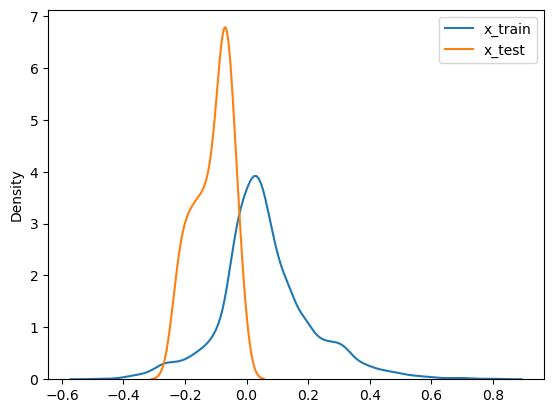

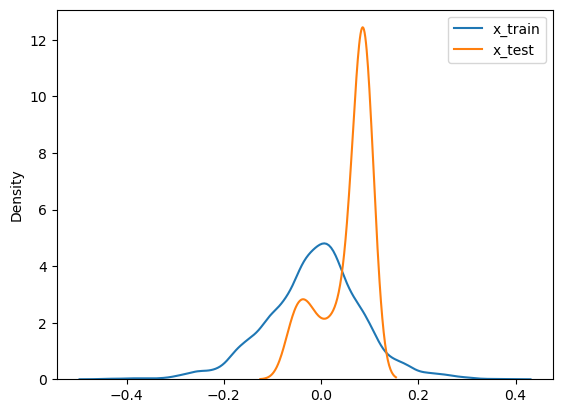

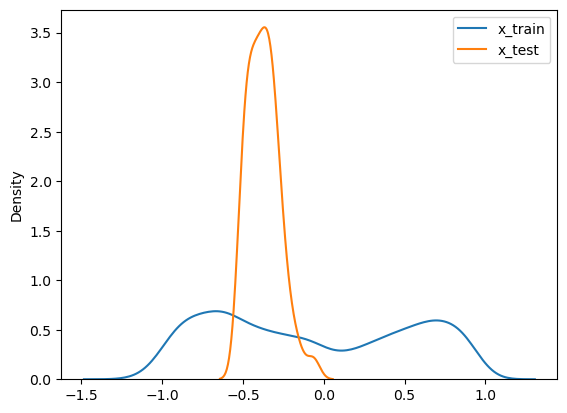

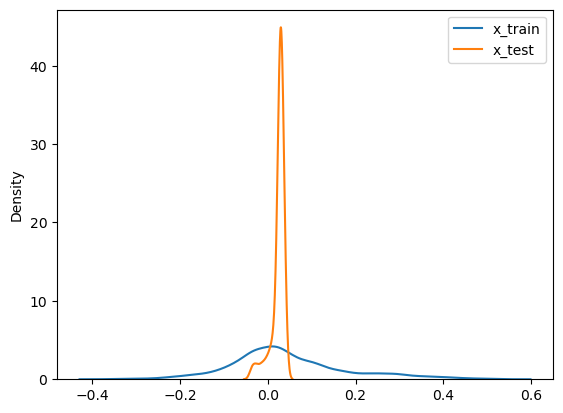

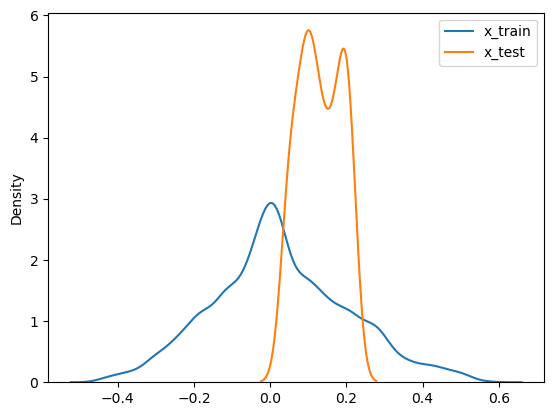

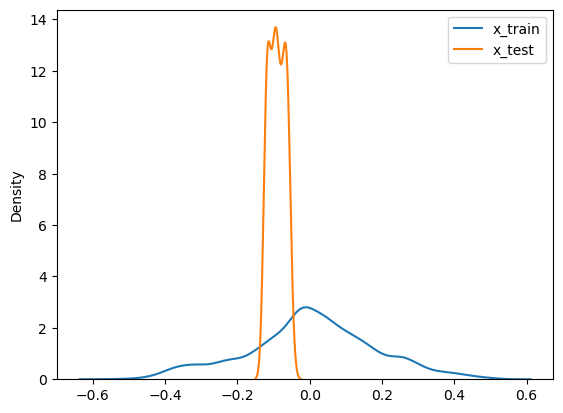

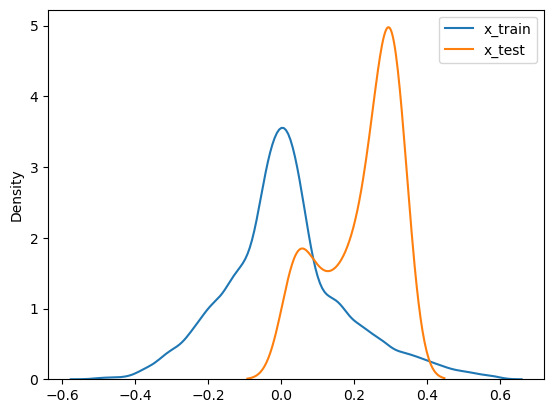

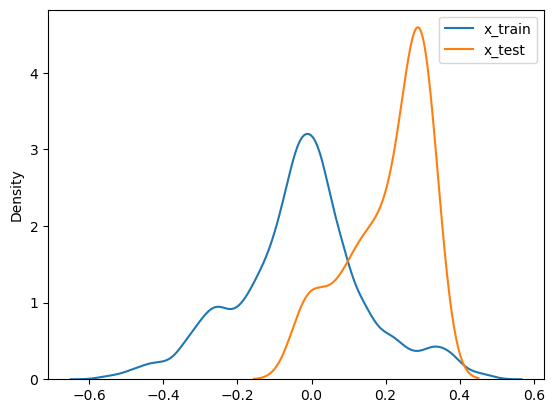

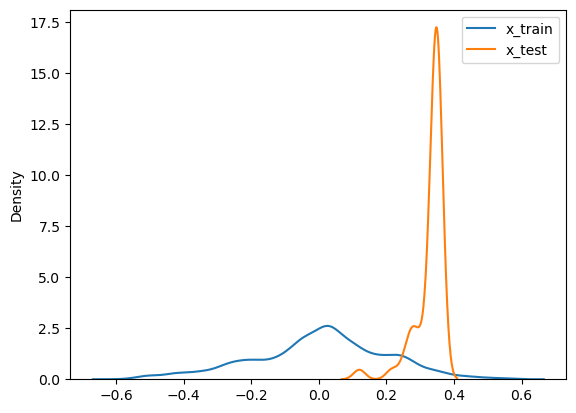

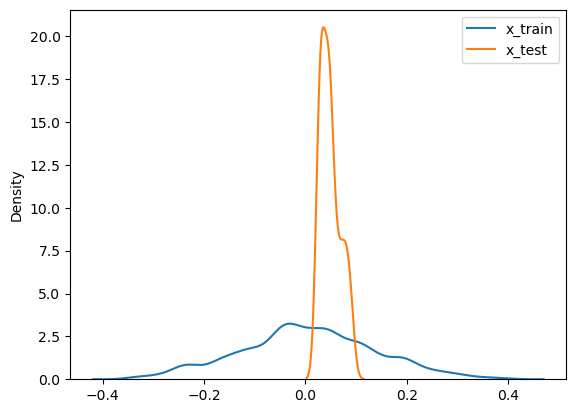

[428, 226, 456, 359, 64, 305, 219, 137, 2, 272]


In [52]:
# Distribution
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

random_numbers = []

for i in range(10):
    random_numbers.append(random.randint(0, 465))
    random_number = random_numbers[-1]
    sns.kdeplot(x_train[:, random_number], label = 'x_train')
    sns.kdeplot(x_test[:, random_number], label = 'x_test')
#     sns.kdeplot(y_train[:, random_number], label = 'y_train')
#     sns.kdeplot(y_test[:, random_number], label = 'y_test')
    plt.legend()
    plt.show()

#     indices = np.unravel_index(range(len(x_train[:, random_number])), x_train[:, random_number].shape)
    
#     density = plt.hist2d(x_train[:, random_number], y_train[:, random_number], bins=len(x_train[:, random_number]), cmap='Blues')[0]
#     colors = density[indices]
#     alphas = density.flatten() / density.max()

#     plt.scatter(x_train[:, random_number], y_train[:, random_number], cmap='Blues', alpha=0.1)


print(random_numbers)

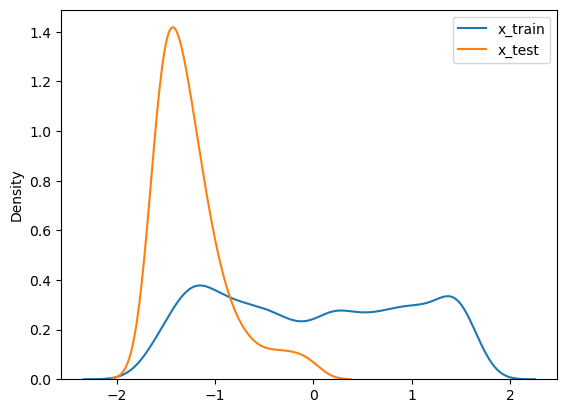

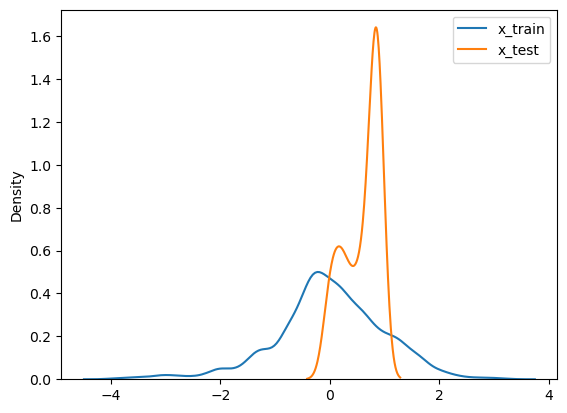

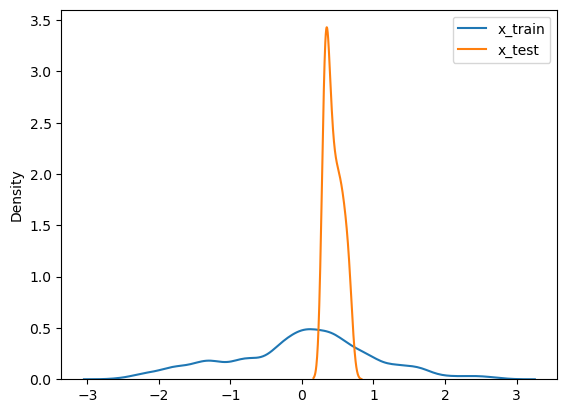

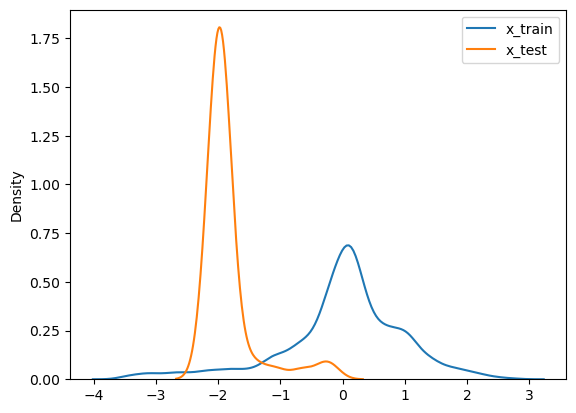

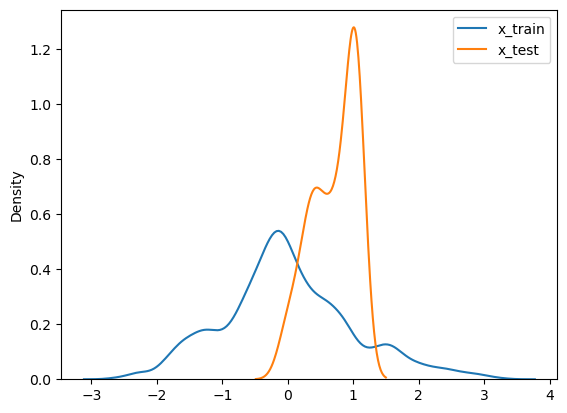

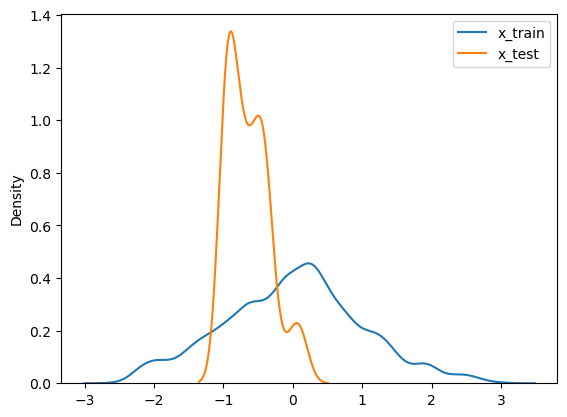

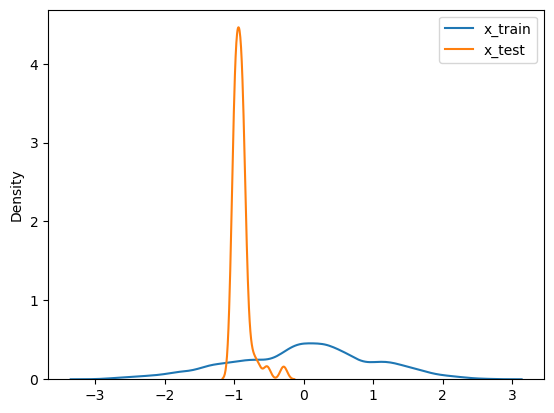

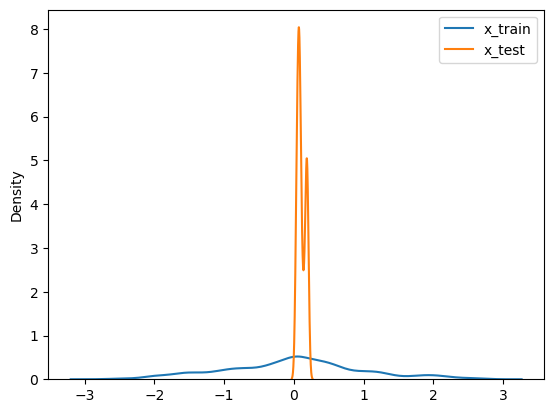

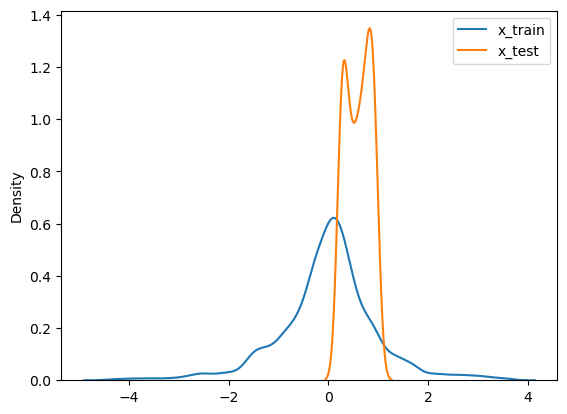

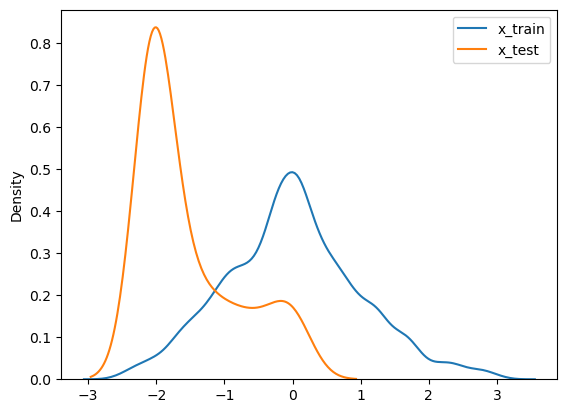

[438, 335, 181, 99, 220, 191, 12, 187, 247, 212]


In [53]:
# Distribution
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

random_numbers = []

for i in range(10):
    random_numbers.append(random.randint(0, 465))
    random_number = random_numbers[-1]
    sns.kdeplot(x_train_scaled[:, random_number], label = 'x_train')
    sns.kdeplot(x_test_scaled[:, random_number], label = 'x_test')
#     sns.kdeplot(y_train[:, random_number], label = 'y_train')
#     sns.kdeplot(y_test[:, random_number], label = 'y_test')
    plt.legend()
    plt.show()

print(random_numbers)

In [54]:
permuted_indices = np.random.permutation(x_train.shape[0])
x_train = x_train[permuted_indices, :]
y_train = y_train[permuted_indices, :]


In [55]:
# Build the model
from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras.layers import Input, Add, Multiply, Lambda, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
import numpy as np
import tensorflow as tf
from tensorflow import keras

class DicNN(Layer):
    """
    Trainable disctionries
    """
    
    def __init__(self, n_input, layer_sizes=[128,128,128], n_psi_train=64, **kwargs):
        """_summary_
        Args:
            layer_sizes (list, optional): Number of unit of hidden layer, activation = 'tanh'. Defaults to [64, 64].
            n_psi_train (int, optional): Number of unit of output layer. Defaults to 22.
        """
        super(DicNN, self).__init__(**kwargs)
        self.layer_sizes = layer_sizes
        self.input_layer = Dense(self.layer_sizes[0], name='Dic_input', use_bias=False)
        self.hidden_layers = [Dense(layer_sizes[i], activation='tanh', name='Dic_hidden_%d'%i) for i in range(len(layer_sizes))]        
        self.output_layer = Dense(n_psi_train, name='Dic_output')
        self.n_psi_train = n_psi_train
        self.inv_input_layer = Dense(self.layer_sizes[-1], name = 'Dic_input_inv', use_bias=False)
        self.inv_hidden_layers = [Dense(layer_sizes[-(i+1)], activation='tanh', name='Dic_hidden_%d_inv'%i) for i in range(len(layer_sizes))]
        self.inv_output_layer = Dense(n_input, name = 'Dic_output_inv')
        self.n_input = n_input
        
    def call(self, inputs):
        psi_x_train = self.input_layer(inputs)
        for layer in self.hidden_layers:
            psi_x_train = psi_x_train + layer(psi_x_train)
        outputs = self.output_layer(psi_x_train)
        return outputs
    
    def inv_call(self, inputs):
        x_inv = self.inv_input_layer(inputs)
        for layer in self.inv_hidden_layers:
            x_inv = x_inv + layer(x_inv)
        outputs = self.inv_output_layer(x_inv)
        return outputs
    
    def get_config(self):
        config = super(DicNN, self).get_config()
        config.update({
            'layer_sizes': self.layer_sizes,
            'n_psi_train': self.n_psi_train
        })
        return config

In [56]:
# from tensorflow.keras import regularizers
# from tensorflow.keras.layers import Dropout
# from tensorflow.keras.layers import Layer, Dense
# from tensorflow.keras.layers import Input, Add, Multiply, Lambda, Concatenate
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers.legacy import Adam
# import numpy as np
# import tensorflow as tf
# from tensorflow import keras

# class DicNN(Layer):
#     """
#     Trainable disctionries
#     """
    
#     def __init__(self, n_input, layer_sizes=[128, 128, 128], n_psi_train=64, dropout_rate=0.005, **kwargs):
#         """_summary_
#         Args:
#             layer_sizes (list, optional): Number of unit of hidden layer, activation = 'tanh'. Defaults to [64, 64].
#             n_psi_train (int, optional): Number of unit of output layer. Defaults to 22.
#         """
#         super(DicNN, self).__init__(**kwargs)
#         self.layer_sizes = layer_sizes
#         self.input_layer = Dense(self.layer_sizes[0], name='Dic_input', use_bias=False, kernel_regularizer=regularizers.l2(0.01))
#         self.hidden_layers = [Dense(layer_sizes[i], activation='tanh', name='Dic_hidden_%d'%i, kernel_regularizer=regularizers.l2(0.01)) for i in range(len(layer_sizes))]        
#         self.output_layer = Dense(n_psi_train, name='Dic_output', kernel_regularizer=regularizers.l2(0.01))
#         self.n_psi_train = n_psi_train
#         self.inv_input_layer = Dense(self.layer_sizes[-1], name = 'Dic_input_inv', use_bias=False, kernel_regularizer=regularizers.l2(0.01))
#         self.inv_hidden_layers = [Dense(layer_sizes[-(i+1)], activation='tanh', name='Dic_hidden_%d_inv'%i, kernel_regularizer=regularizers.l2(0.01)) for i in range(len(layer_sizes))]
#         self.inv_output_layer = Dense(n_input, name = 'Dic_output_inv', kernel_regularizer=regularizers.l2(0.01))
#         self.n_input = n_input
#         self.dropout_layers = [Dropout(dropout_rate) for _ in range(len(layer_sizes))]
        
#     def call(self, inputs):
#         psi_x_train = self.input_layer(inputs)
#         for i, layer in enumerate(self.hidden_layers):
#             psi_x_train = psi_x_train + layer(psi_x_train)
#             psi_x_train = self.dropout_layers[i](psi_x_train)
#         outputs = self.output_layer(psi_x_train)
#         return outputs
    
#     def inv_call(self, inputs):
#         x_inv = self.inv_input_layer(inputs)
#         for i, layer in enumerate(self.inv_hidden_layers):
#             x_inv = x_inv + layer(x_inv)
#             x_inv = self.dropout_layers[i](x_inv)
#         outputs = self.inv_output_layer(x_inv)
#         return outputs
    
#     def get_config(self):
#         config = super(DicNN, self).get_config()
#         config.update({'layer_sizes': self.layer,           
#                        'n_psi_train': self.n_psi_train,
#             'dropout_rate': self.dropout_rate
#         })
#         return config



In [57]:
dic = DicNN(n_input = np.shape(x_train)[1])
inputs_x = Input((np.shape(x_train)[1],))
model_psi = Model(inputs = inputs_x, outputs = dic.call(inputs_x))

In [58]:
model_psi.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 466)]        0           []                               
                                                                                                  
 Dic_input (Dense)              (None, 128)          59648       ['input_8[0][0]']                
                                                                                                  
 Dic_hidden_0 (Dense)           (None, 128)          16512       ['Dic_input[0][0]']              
                                                                                                  
 tf.__operators__.add_6 (TFOpLa  (None, 128)         0           ['Dic_input[0][0]',              
 mbda)                                                            'Dic_hidden_0[0][0]']     

In [59]:
@tf.function
def eigenloss(matrix, static_num, epsilon):
    eigvalues = tf.linalg.eigvals(matrix)
    static_values, dynamic_values = eigvalues[:static_num], eigvalues[static_num:]
    E1 = tf.reduce_sum(tf.abs(static_values - 1)**2)
    dynamic_values = tf.where(tf.abs(dynamic_values) < epsilon, tf.zeros_like(dynamic_values), dynamic_values)
    E2 = tf.reduce_sum(tf.abs(dynamic_values)**2)
    return E1, E2

In [60]:
inputs_x = Input((np.shape(x_train)[1],))
inputs_y = Input((np.shape(y_train)[1],))
psi_x = model_psi(inputs_x)
psi_y = model_psi(inputs_y)
k_layer = Dense(units = dic.n_psi_train, use_bias=False, name = 'k_layer')
outputs_x = k_layer(psi_x)
outputs = outputs_x - psi_y
model_koopman = Model(inputs = [inputs_x, inputs_y], outputs = outputs)

In [61]:
model_koopman.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 466)]        0           []                               
                                                                                                  
 model_5 (Functional)           (None, 64)           117440      ['input_9[0][0]',                
                                                                  'input_10[0][0]']               
                                                                                                  
 input_10 (InputLayer)          [(None, 466)]        0           []                               
                                                                                                  
 k_layer (Dense)                (None, 64)           4096        ['model_5[0][0]']          

In [62]:
inputs_x = Input((np.shape(x_train)[1],))
psi_x = model_psi(inputs_x)
inputs_kpsi = Input((dic.n_psi_train,))
model_inv_psi = Model(inputs = inputs_kpsi, outputs = dic.inv_call(inputs_kpsi))
model_auto = Model(inputs = inputs_x, outputs = model_inv_psi(psi_x))

In [63]:
model_auto.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 466)]             0         
                                                                 
 model_5 (Functional)        (None, 64)                117440    
                                                                 
 model_7 (Functional)        (None, 466)               117842    
                                                                 
Total params: 235,282
Trainable params: 235,282
Non-trainable params: 0
_________________________________________________________________


In [64]:
input_x = tf.keras.layers.Input(shape=(x_train.shape[1],))
input_y = tf.keras.layers.Input(shape=(y_train.shape[1],))
output_auto = model_auto(input_x)
output_koopman = model_koopman([input_x, input_y])
combined_model = tf.keras.models.Model(inputs=[input_x, input_y], outputs=[output_auto, output_koopman])

In [65]:
def custom_loss(alpha, beta, epsilon, static_num, model_auto, model_koopman):
    def loss(y_true, y_pred):
        
        # Compute the maximum eigenvalue of the k_layer
#         k_layer = model_koopman.get_layer('k_layer')
#         matrix = k_layer.trainable_variables[0]
#         E1, E2 = eigenloss(matrix, static_num, epsilon)
        
        # Compute the Koopman operator loss
        koopman_loss = tf.keras.losses.MSE(y_pred[1], y_true[1])
    
        # Compute the reconstruction loss
        recon_loss = tf.keras.losses.MSE(y_pred[0], y_true[0])
        
        # Compute the final loss
        return alpha * koopman_loss + beta * recon_loss
    return loss

In [66]:
batch_size = 256
epochs = 500
alpha = 1
beta = 1
# gamma = [0.05,0.05]
gamma = [0,0]
epsilon = 0.8
static_num = 3

In [67]:
combined_model.compile(optimizer='adam', loss=custom_loss(alpha, beta,epsilon, static_num, model_auto, model_koopman))

In [68]:
# combined_model.compile(optimizer='adam', loss='mse')

In [69]:
combined_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 466)]        0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 466)]        0           []                               
                                                                                                  
 model_8 (Functional)           (None, 466)          235282      ['input_13[0][0]']               
                                                                                                  
 model_6 (Functional)           (None, 64)           121536      ['input_13[0][0]',               
                                                                  'input_14[0][0]']         

In [70]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
y_train_scaled = scaler.transform(y_train)
x_test_scaled = scaler.transform(x_test)
y_test_scaled = scaler.transform(y_test)

In [71]:
# history = combined_model.fit([x_train_scaled, y_train_scaled], 
#                    [x_train_scaled, tf.zeros_like(model_psi(x_train_scaled))], 
#                    validation_data=([x_test_scaled, y_test_scaled], 
#                                     [x_test_scaled, tf.zeros_like(model_psi(x_test_scaled))]),
#                    epochs=epochs, batch_size=batch_size)

In [72]:
# history = combined_model.fit([x_train, y_train], 
#                    [x_train, tf.zeros_like(model_psi(x_train))], 
#                    validation_data=([x_test, y_test], 
#                                     [x_test, tf.zeros_like(model_psi(x_test))]),
#                    epochs=epochs, batch_size=batch_size)

In [ ]:
model_auto.compile(optimizer='adam', loss='mse')
model_auto.fit(x_train_scaled, x_train_scaled,  
               validation_data=(x_test_scaled,x_test_scaled),
               epochs=100, batch_size=batch_size)

Epoch 1/100
54/54 [==============================] - 2s 13ms/step - loss: 1.0828 - val_loss: 0.9272
Epoch 2/100
54/54 [==============================] - 1s 11ms/step - loss: 0.5979 - val_loss: 0.7900
Epoch 3/100
54/54 [==============================] - 1s 11ms/step - loss: 0.4404 - val_loss: 0.6781
Epoch 4/100
54/54 [==============================] - 1s 11ms/step - loss: 0.3532 - val_loss: 0.6376
Epoch 5/100
54/54 [==============================] - 1s 11ms/step - loss: 0.2984 - val_loss: 0.6265
Epoch 6/100
54/54 [==============================] - 1s 11ms/step - loss: 0.2587 - val_loss: 0.6350
Epoch 7/100
54/54 [==============================] - 1s 11ms/step - loss: 0.2271 - val_loss: 0.6530
Epoch 8/100
54/54 [==============================] - 1s 11ms/step - loss: 0.2020 - val_loss: 0.6628
Epoch 9/100
54/54 [==============================] - 1s 11ms/step - loss: 0.1822 - val_loss: 0.6707
Epoch 10/100
54/54 [==============================] - 1s 11ms/step - loss: 0.1666 - val_loss: 0.6739

In [44]:
x_train_recon = model_auto(x_train_scaled)
x_test_recon = model_auto(x_test_scaled)

In [45]:
print(x_train_recon)

tf.Tensor(
[[-2.363999    1.487918   -0.09013641 ... -0.58130115  0.6122739
  -0.568928  ]
 [-0.28841943 -1.1117785  -1.1559125  ... -0.44472778 -0.5804894
   0.7669055 ]
 [-0.5527287  -0.45212498  1.2917473  ...  0.02929228  1.8385861
  -1.5764817 ]
 ...
 [-1.175797   -0.25817594  1.7769215  ... -0.7910519  -1.8577904
   1.835326  ]
 [-0.3291013  -1.1091416   0.36137545 ... -1.6156018   0.7290223
  -0.45416582]
 [ 0.8334959   0.14434929 -0.774942   ... -0.5156113  -0.39439887
   0.4933709 ]], shape=(12250, 466), dtype=float32)


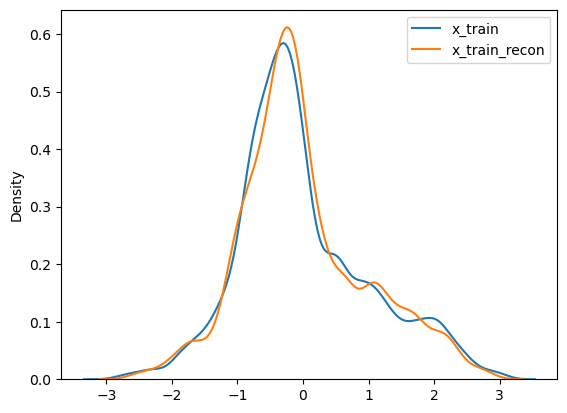

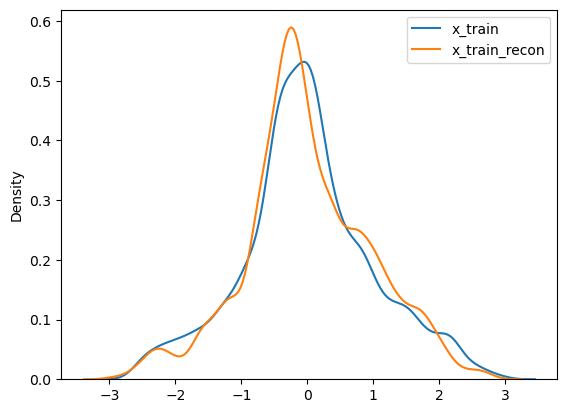

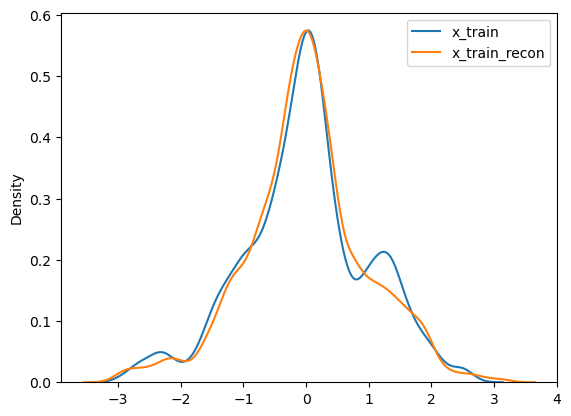

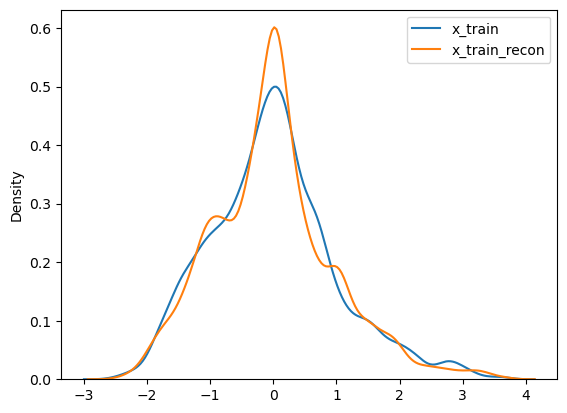

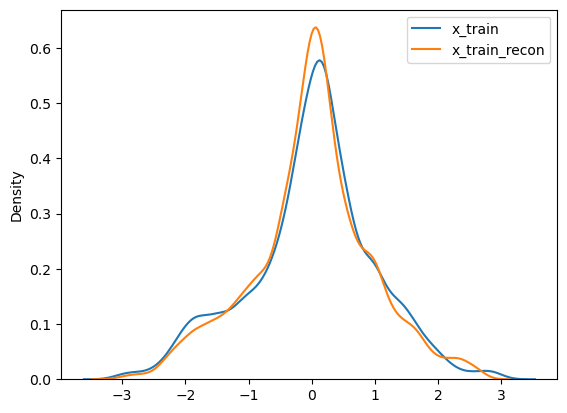

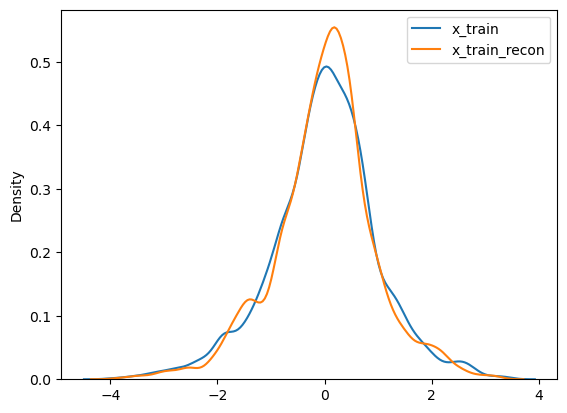

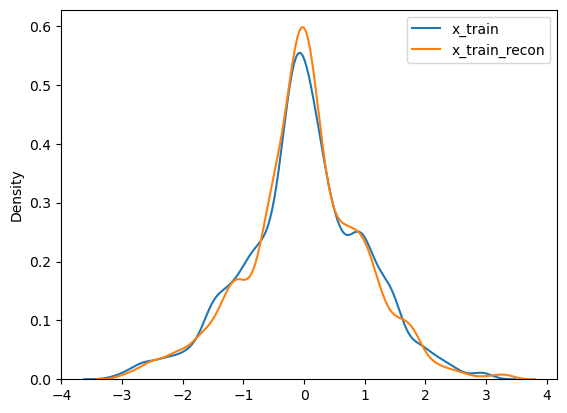

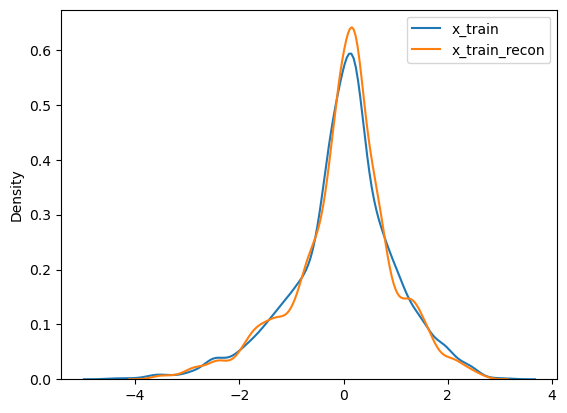

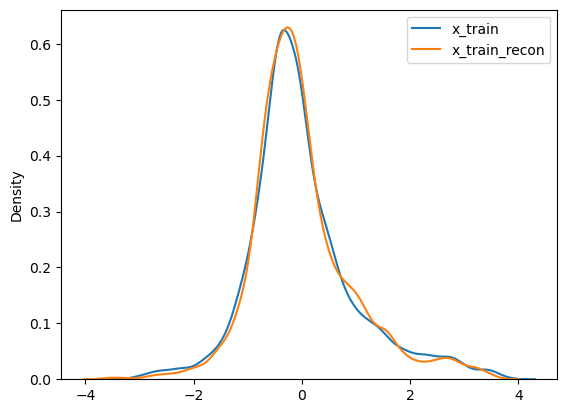

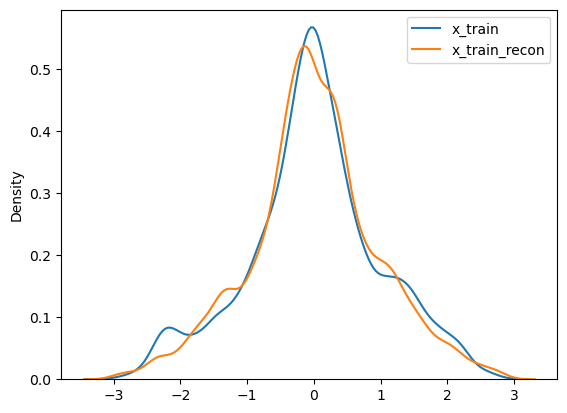

[156, 283, 4, 221, 46, 404, 8, 327, 355, 39]


In [46]:
# Distribution
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

random_numbers = []

for i in range(10):
    random_numbers.append(random.randint(0, 465))
    random_number = random_numbers[-1]
    sns.kdeplot(x_train_scaled[:, random_number], label = 'x_train')
    sns.kdeplot(x_train_recon[:, random_number], label = 'x_train_recon')
#     sns.kdeplot(x_test_scaled[:, random_number], label = 'x_test')
#     sns.kdeplot(x_test_recon[:, random_number], label = 'x_test_recon')
    plt.legend()
    plt.show()

print(random_numbers)

In [47]:
x_train[:10,:]

array([[-0.47065142,  0.3167789 , -0.00305821, ..., -0.28925437,
         0.4433047 , -0.4508537 ],
       [-0.028844  , -0.13624933, -0.23803322, ..., -0.37459022,
         0.22573741, -0.16413665],
       [-0.14443053, -0.1544521 ,  0.2599661 , ...,  0.13598804,
         0.75406414, -0.6831669 ],
       ...,
       [-0.034026  ,  0.11138754, -0.18988888, ...,  0.5408782 ,
         0.4071886 , -0.391601  ],
       [-0.3600696 , -0.13338958, -0.19125009, ...,  0.58946043,
         0.17176482, -0.20431063],
       [ 0.4563358 ,  0.14366545,  0.26122555, ...,  0.85802674,
         0.17556942, -0.1836492 ]], dtype=float32)

In [66]:
# # model_auto.compile(optimizer='adam', loss='mse')
# # model_auto.fit(x_train_scaled, x_train_scaled,  
# #                validation_data=(x_test_scaled,x_test_scaled),
# #                epochs=50, batch_size=batch_size)
# model_auto.fit(x_test_scaled,x_test_scaled,  
#                validation_data=(x_train_scaled, x_train_scaled),
#                epochs=50, batch_size=batch_size)

In [67]:
k_layer = model_koopman.get_layer('k_layer')
matrix = k_layer.trainable_variables[0]
eigenvalues, eigenvectors = tf.linalg.eig(matrix)
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle

# Extract real and imaginary parts
real_part = np.real(eigenvalues)
imag_part = np.imag(eigenvalues)

In [68]:
eigenvalues

<tf.Tensor: shape=(64,), dtype=complex64, numpy=
array([-0.3257929 +1.0268452j , -0.3257929 -1.0268452j ,
        0.9351326 +0.30273065j,  0.9351326 -0.30273065j,
        0.8628385 +0.46369627j,  0.8628385 -0.46369627j,
        0.6212727 +0.71078974j,  0.6212727 -0.71078974j,
        0.21382605+0.87017655j,  0.21382605-0.87017655j,
       -0.06184718+0.8786234j , -0.06184718-0.8786234j ,
       -0.82495975+0.33568683j, -0.82495975-0.33568683j,
       -0.68334055+0.547912j  , -0.68334055-0.547912j  ,
       -0.45623296+0.75514543j, -0.45623296-0.75514543j,
        0.52797693+0.65010494j,  0.52797693-0.65010494j,
       -0.49195737+0.6636447j , -0.49195737-0.6636447j ,
       -0.796617  +0.j        ,  0.20539834+0.72648746j,
        0.20539834-0.72648746j,  0.6864313 +0.27722782j,
        0.6864313 -0.27722782j, -0.73823124+0.j        ,
       -0.51614386+0.45406947j, -0.51614386-0.45406947j,
       -0.67361784+0.11701548j, -0.67361784-0.11701548j,
       -0.5358475 +0.33960032j, -0.5358

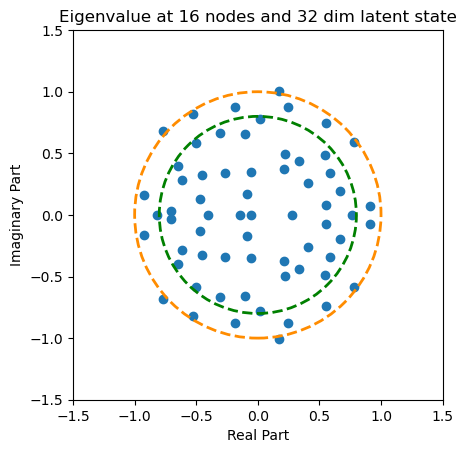

In [32]:
fig, ax = plt.subplots()
ax.scatter(real_part, imag_part)

# Label the axes
ax.set_xlabel('Real Part')
ax.set_ylabel('Imaginary Part')

# Label the caption
plt.title('Eigenvalue at %d nodes and 32 dim latent state' % node_num)

# Add the unit circle
unit_circle = Circle((0, 0), radius=1, fill=False, linestyle='--', linewidth=2, color = 'darkorange')
half_circle = Circle((0, 0), radius=0.8, fill=False, linestyle='--', linewidth=2, color = 'green')

ax.add_artist(unit_circle)
ax.add_artist(half_circle)


# Set the axis limits to show the full circle
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
ax.set_aspect('equal')


# Show the plot
plt.show()


In [22]:
U = eigenvectors
U_inv = tf.linalg.inv(U)
U_inv_static = np.zeros(tf.shape(U_inv))
for i in range(len(eigenvalues)):
    eig = eigenvalues[i]
    if tf.abs(eig) > epsilon:
        U_inv_static[i,:] = tf.abs(U_inv[i,:])        

In [21]:
# U = eigenvectors
# U_inv = tf.linalg.inv(U)
# U_inv_static = tf.zeros_like(U_inv)
# for i in range(static_num):
#     U_inv_static = tf.tensor_scatter_nd_update(U_inv_static,
#                                                 indices=[[i]],
#                                                 updates=[tf.abs(eigenvalues[i] * U_inv[i, :])])
# print(U_inv_static)


tf.Tensor(
[[0.02329242+0.j 0.03142685+0.j 0.0200076 +0.j ... 0.14382964+0.j
  0.01192444+0.j 0.03404916+0.j]
 [0.05202407+0.j 0.02592809+0.j 0.19715963+0.j ... 0.14043681+0.j
  0.13705724+0.j 0.09682909+0.j]
 [0.0520242 +0.j 0.0259282 +0.j 0.19715962+0.j ... 0.14043705+0.j
  0.13705724+0.j 0.09682904+0.j]
 ...
 [0.        +0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.        +0.j]], shape=(32, 32), dtype=complex64)


In [22]:
model_psi(x_train_scaled[:1,:])

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[-0.19731663,  0.01121156,  0.5505918 ,  0.7119236 , -0.43271193,
         0.44589722,  0.06963895, -0.56004035, -0.43447953,  0.6557389 ,
         0.45861855,  0.21972503, -0.21564569, -0.3520559 , -0.19093528,
        -0.4065676 , -0.5687215 , -0.280802  ,  0.4333609 , -0.14292045,
        -0.21930373,  0.05958398,  0.539366  , -0.28651774,  0.33915028,
        -0.15365338, -0.41353112, -0.08747441, -0.08405096,  0.201535  ,
         0.32425377, -0.5103728 ]], dtype=float32)>

In [24]:
static_para_scaled = model_inv_psi(model_psi(x_train_scaled[200:201,:]) @ tf.math.real(tf.abs(U)) @ U_inv_static)

In [25]:
static_para = scaler.inverse_transform(static_para_scaled)
np.shape(static_para)

(1, 466)

In [25]:
node_num = 16

In [28]:
inputs = keras.Input(shape=(26,), name="digits")
x = keras.layers.Dense(node_num, activation="relu", kernel_initializer="uniform",bias_initializer="uniform")(inputs)
outputs = keras.layers.Dense(2, name="predictions",kernel_initializer="uniform",bias_initializer="uniform")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
start_idx = 0
for i, w in enumerate(model.trainable_weights):
    w_shape = w.shape
    print(w_shape)
    w_size = tf.reduce_prod(w_shape)
    end_idx = start_idx + w_size
    w.assign(tf.cast(tf.reshape(static_para[0, start_idx:end_idx], w_shape), tf.float32))
    start_idx = end_idx

(26, 16)
(16,)
(16, 2)
(2,)


In [26]:
from sklearn.decomposition import PCA
import numpy as np
import tensorflow as tf

# Load MNIST data.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocessing: normalize pixel values to be between 0 and 1.
x_train = x_train / 255.0
x_test = x_test / 255.0

# Shuffle training data.
shuffle_index = np.random.permutation(len(x_train))
x_train, y_train = x_train[shuffle_index], y_train[shuffle_index]

# Convert target labels to binary classification (digit < 5 or digit >= 5).
y_train = (y_train < 5)
y_test = (y_test < 5)

# Convert labels to one-hot encoding.
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

# Track the data type of x_train.
dataType = x_train.dtype
print(f"Data type: {dataType}")

# Track the data type of y_test.
labelType = y_test.dtype
print(f"Data type: {labelType}")

# Print the one-hot encoded label for the first training example.
print(y_train[0])

# Instantiate the training dataset.
x_train = np.reshape(x_train, (-1, 784))
x_test = np.reshape(x_test, (-1, 784))

# Perform PCA to reduce dimensionality of x_train.
pca = PCA(n_components=0.7)  # retain 70% of variance
x_train_reduced = pca.fit_transform(x_train.reshape(x_train.shape[0], -1))
x_test_reduced = pca.transform(x_test.reshape(x_test.shape[0], -1))

# Print the dimensions of the original and reduced datasets.
print("Original dimensions:", x_train.shape)
print("Reduced dimensions:", x_train_reduced.shape)

Data type: float64
Data type: float32
[1. 0.]
Original dimensions: (60000, 784)
Reduced dimensions: (60000, 26)


In [29]:
# Instantiate an optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
# Instantiate a loss function.
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
# Compile the model
model.compile(optimizer=optimizer, loss=loss_fn,  metrics=["accuracy"])        
model.evaluate(x_train_reduced, y_train)

1875/1875 [==============================] - 3s 1ms/step - loss: 3.7719 - accuracy: 0.5250


[3.7718942165374756, 0.5250499844551086]